In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from helper import *
from scipy import stats
from sklearn import preprocessing
from sklearn.impute import SimpleImputer

%matplotlib inline

# Select and Re-Encode Features

In [104]:
dtype={'CAMEO_DEUG_2015': 'object', 'CAMEO_INTL_2015': 'object'}
customers = pd.read_csv('./data/Udacity_CUSTOMERS_052018.csv', sep=';',  dtype= dtype, nrows = 5000)

azdias = pd.read_csv('./data/Udacity_AZDIAS_052018.csv', sep=';', dtype = dtype, nrows = 5000)
del azdias['LNR']

In [105]:
cols_to_drop = np.setdiff1d(customers.columns, azdias.columns)
customers.drop(cols_to_drop, axis=1, inplace=True)

In [106]:
feat_summary = pd.read_pickle('feat_summary.pkl')
feat_summary.head()

,Attribute,type,Value
0,KBA13_KMH_140_210,ordinal,[-1]
1,CJT_GESAMTTYP,categorical,[0]
2,FINANZ_VORSORGER,ordinal,[-1]
3,D19_GARTEN,ordinal,NaN
4,KBA05_CCM2,ordinal,"[-1, 9]"


In [107]:
num_cols = get_features(feat_summary, typ="numerical" )
cat_cols = get_features(feat_summary, typ="categorical")
ord_cols = get_features(feat_summary, typ="ordinal")

## convert missing values or unknowns

I noticed from the data set that unknows of some features are presented using more than one values, ('HH_EINKOMMEN_SCORE' : [-1, 0]). In this section, I will use information in the feature summary file (feat_summary.pkl), to re-assign a value to unknowns in the data. 

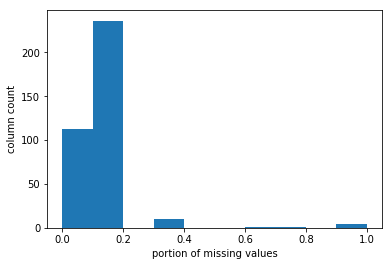

In [108]:
# hist before updating the dataframe
hist_nan(azdias, axis=0)

In [109]:
azdias = unkown_mapping(azdias, feat_summary)

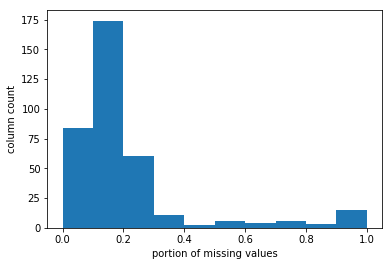

In [110]:
hist_nan(azdias, axis=0)

## outlier detection 

I will use a simple method to identify outlier: zscore. If any data has a zscore larger than 3, it will be treated as outlier. The columns with outlier will be further examined, and re-assigned with a data type if it is necessary.

In [111]:
# # Check if the dataframe still contain any strings or any other non-numeric values 
# cols = []
# for col in azdias.columns:
#     if any(isinstance(y,(str)) for y in azdias[col].unique()):  
#         print('{:}, {:}'.format( col , azdias[col].unique()))
#         cols.append(col)

In [112]:
# Unknown of some features are encoded as 'X' or 'XX', replace them as np.nan, we will convert the others 
azdias.replace(['X','XX'], np.nan, inplace=True)

In [113]:
column_with_outliers = []

for col in ord_cols: 
    
    values = azdias[col].dropna()
    if (np.abs(stats.zscore(values)) > 3).any():
#         fig, ax = plt.subplots()
#         sns.countplot(values)
        print(col)
        column_with_outliers.append(col)

D19_GARTEN
KBA13_KRSSEG_KLEIN
D19_WEIN_FEINKOST
D19_VERSAND_ANZ_12
D19_TELKO_ANZ_12
D19_BANKEN_REST
D19_VERSAND_OFFLINE_DATUM
D19_BILDUNG
D19_SAMMELARTIKEL
D19_BANKEN_DIREKT
D19_BANKEN_ANZ_24
D19_SCHUHE
D19_VERSI_OFFLINE_DATUM
PLZ8_ANTG2
D19_DROGERIEARTIKEL
WOHNDAUER_2008
D19_BANKEN_LOKAL
D19_TELKO_ONLINE_QUOTE_12
D19_TELKO_ONLINE_DATUM
D19_NAHRUNGSERGAENZUNG
D19_TELKO_OFFLINE_DATUM
KBA13_KRSSEG_OBER
D19_TIERARTIKEL
D19_RATGEBER
KBA13_KRSHERST_BMW_BENZ
D19_VERSI_ONLINE_DATUM
D19_BANKEN_ONLINE_QUOTE_12
D19_BIO_OEKO
D19_HANDWERK
D19_VERSI_ONLINE_QUOTE_12
KBA13_KRSSEG_VAN
D19_VERSI_DATUM
D19_GESAMT_OFFLINE_DATUM
D19_BANKEN_ANZ_12
D19_FREIZEIT
D19_BANKEN_GROSS
KBA13_ANZAHL_PKW
D19_TELKO_DATUM
D19_VERSI_ANZ_12
D19_VERSAND_REST
D19_TELKO_ANZ_24
D19_LEBENSMITTEL
D19_VERSI_ANZ_24
D19_BEKLEIDUNG_GEH
D19_DIGIT_SERV
D19_TELKO_REST
D19_ENERGIE


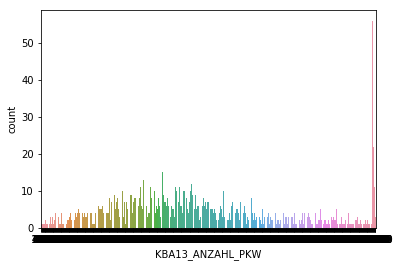

In [114]:
sns.countplot(azdias["KBA13_ANZAHL_PKW"])

From the count plots above, it is concluded that columns with outliers are mostly the ones not explicitly explained the information file, and assumed to be ordinal information at earlier analysis. Since there isn't much information avaialbe about those data, I will asign a very simple rule to treat those columns, 

- for columns with small range, i will treat those as categorical. 
- for ones with a large range, I will treat them as numerical.

In [115]:
to_num = ['KBA13_ANZAHL_PKW', 'VERDICHTUNGSRAUM']
azdias[to_num].describe()

,KBA13_ANZAHL_PKW,VERDICHTUNGSRAUM
count,4187.000000,2230.000000
mean,626.002627,9.024215
std,349.657587,10.371448
min,0.000000,1.000000
25%,390.000000,1.000000
50%,554.000000,5.000000
75%,775.000000,13.000000
max,2300.000000,45.000000


In [116]:
to_cat = np.setdiff1d(column_with_outliers, to_num)

In [117]:
# update the feature summary
cat_cols = np.concatenate([cat_cols, to_cat])
# np.num_cols 

In [118]:
# update the feat_summary

In [119]:
for col in to_num:
    feat_summary.loc[feat_summary["Attribute"] == col, 'type'] = 'numerical'

In [120]:
for col in to_cat:
    feat_summary.loc[feat_summary["Attribute"] == col, 'type'] = 'categorical'

##  Drop rows that have large number of missing

distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. 

In [121]:
threshold = 1.0
azdias = drop_columns(azdias, threshold = threshold)
azdias = drop_rows(azdias, threshold = threshold)
feature_count(azdias)

Demographics data file contains 365 features


## Imputation

In [122]:
## Summary of nans for  each column
# NaN count in columns where
azdias_nan  = azdias.isna().mean() * 100 #portion of NaN
azdias_nan_ = azdias_nan.loc[azdias_nan> 20]

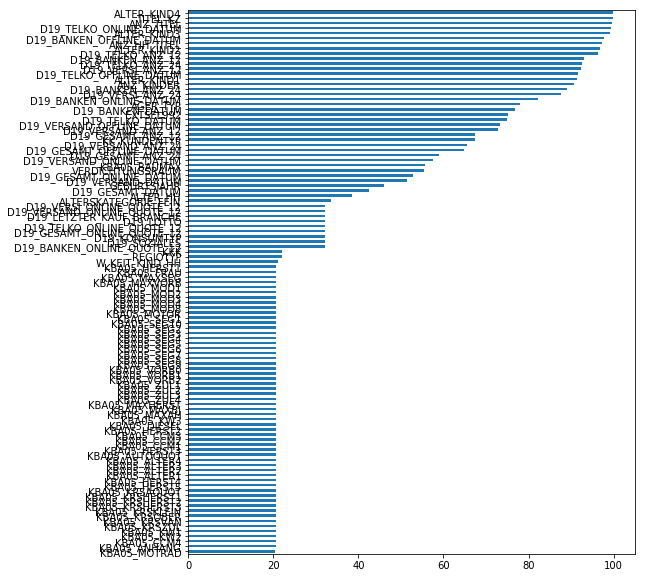

In [123]:
azdias_nan_.sort_values(ascending=True).plot(kind = 'barh', figsize = (8,10))

## 

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. 

- For numeric and interval data, these features needs to be scaled 
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes). -> to be scaled
- Special handling may be necessary for the remaining two variable types: categorical
- Mixed data is also treated the same way as cat-data

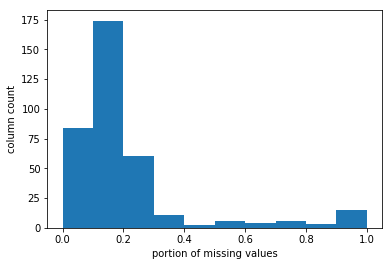

In [124]:
hist_nan(azdias)

#### Imputing missing value

In [125]:
azdias

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,NaN,9.0,NaN,NaN,NaN,NaN,NaN,21.0,11.0,NaN,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,NaN,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,NaN,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,2.0,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,NaN,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,NaN,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,NaN,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,NaN,4.0,19.0,NaN,NaN,NaN,NaN,19.0,2.0,NaN,...,1.0,2.0,3.0,7.0,6.0,4.0,3.0,4,2,1
4996,NaN,1.0,14.0,NaN,NaN,NaN,NaN,14.0,1.0,NaN,...,2.0,2.0,3.0,3.0,3.0,9.0,7.0,3,2,4
4997,NaN,9.0,15.0,16.0,NaN,NaN,NaN,15.0,2.0,NaN,...,4.0,3.0,6.0,4.0,1.0,9.0,1.0,1,1,3
4998,NaN,1.0,12.0,NaN,NaN,NaN,NaN,12.0,2.0,1.0,...,3.0,NaN,NaN,NaN,6.0,9.0,1.0,3,2,1


In [126]:
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
azdias_transformed = pd.DataFrame(imp.fit_transform(azdias))

In [127]:
# azdias

In [128]:
# # Replace NaN using the most frequent item in each column
# imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
# azdias_transformed = pd.DataFrame(imp.fit_transform(azdias))

azdias_transformed.columns= azdias.columns
azdias_transformed.index=azdias.index

In [129]:
# azdias

#### handle cat features

In [130]:
to_label_encoder = ["OST_WEST_KZ","CAMEO_DEUG_2015", "CAMEO_DEU_2015", "CAMEO_INTL_2015", 'D19_LETZTER_KAUF_BRANCHE']

In [131]:
le = preprocessing.LabelEncoder()

for col in to_label_encoder:
    try:
        azdias_transformed[col] = le.fit_transform(azdias_transformed[col])
    except:
        print('{:} not in dataframe'.format(col))

In [132]:
# cat_cols

In [133]:
cat_cols = np.intersect1d(cat_cols, azdias_transformed.columns)
azdias_transformed[cat_cols] = azdias_transformed[cat_cols].astype('category')
azdias_transformed = pd.get_dummies(azdias_transformed, drop_first= True, columns= cat_cols)

In [134]:
# azdias

## Feature Transformation

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the API reference page for sklearn to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:
sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. 

This can be as simple as just removing all data points with missing data, or applying an Imputer to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.

For the actual scaling function, a StandardScaler instance is suggested, scaling each feature to mean 0 and standard deviation 1.

For these classes, you can make use of the .fit_transform() method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

apply feature scaling to the numeric columns. ordinal values converted to [0,1] already. therefore there is no need to convert those columns 

In [135]:
# pd.DatetimeIndex(azdias_transformed['EINGEFUEGT_AM']).year

In [136]:
azdias_transformed['EINGEFUEGT_AM'] = pd.DatetimeIndex(azdias_transformed['EINGEFUEGT_AM']).year

In [137]:
get_features(feat_summary, 'numerical' )

array(['ANZ_KINDER', 'ALTER_KIND2', 'EXTSEL992', 'ANZ_PERSONEN',
       'ANZ_HH_TITEL', 'EINGEZOGENAM_HH_JAHR', 'ANZ_HAUSHALTE_AKTIV',
       'ANZ_TITEL', 'ALTER_KIND1', 'MIN_GEBAEUDEJAHR', 'EINGEFUEGT_AM',
       'KBA13_ANZAHL_PKW', 'ALTER_KIND4', 'GEBURTSJAHR',
       'VERDICHTUNGSRAUM', 'ANZ_STATISTISCHE_HAUSHALTE', 'VK_DISTANZ'],
      dtype=object)

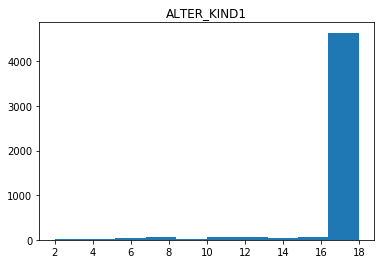

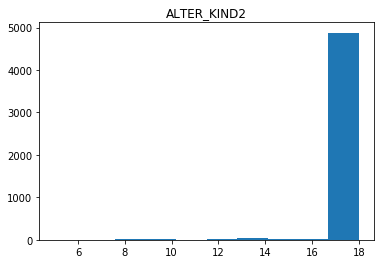

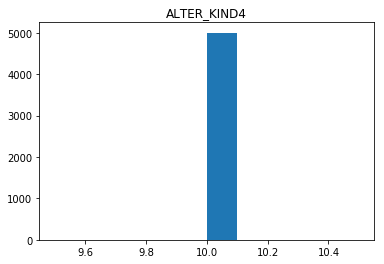

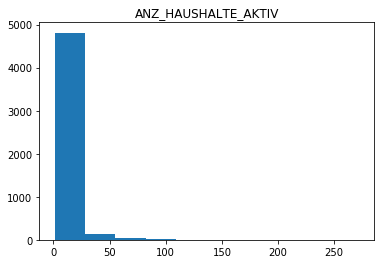

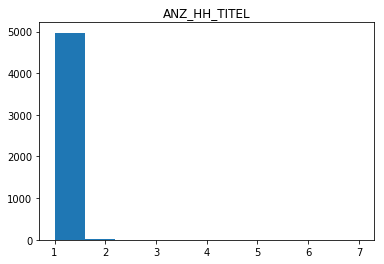

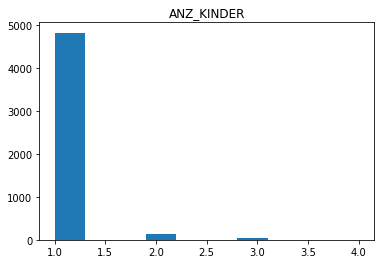

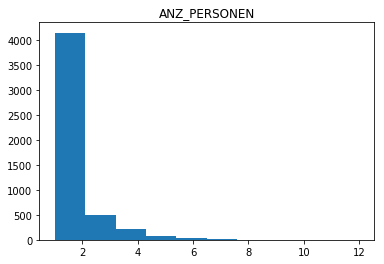

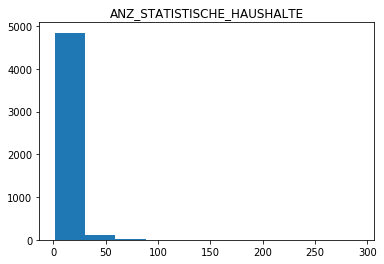

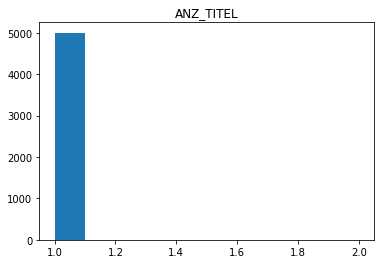

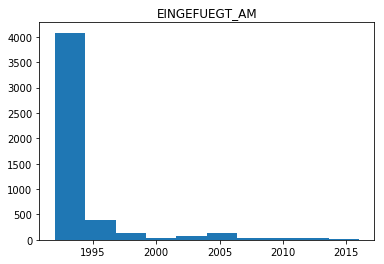

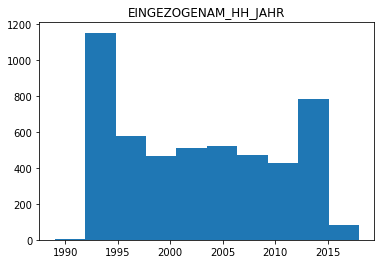

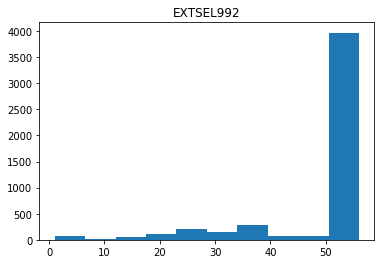

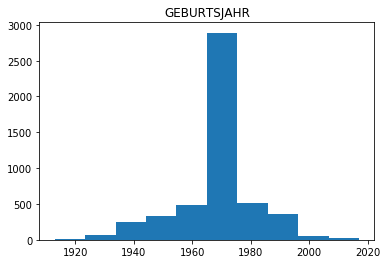

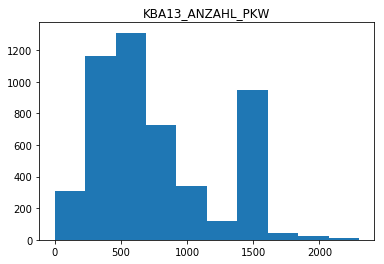

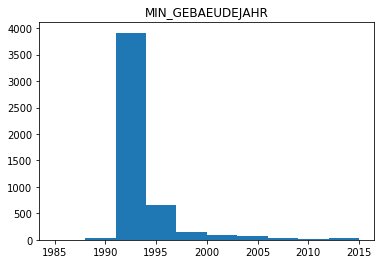

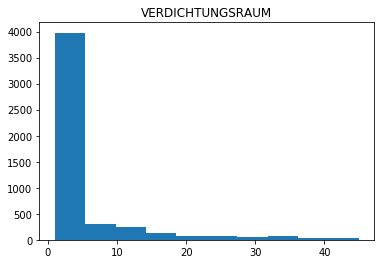

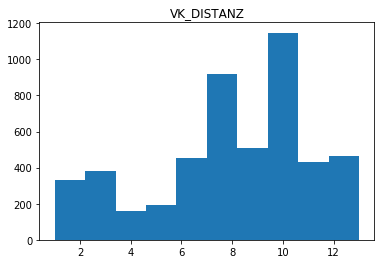

In [139]:
num_cols = get_features(feat_summary, 'numerical', azdias_transformed )
azdias_transformed[num_cols] = azdias_transformed[num_cols].astype('int64')

# print(num_cols)

for col in num_cols:
    fig, ax = plt.subplots()
    plt.hist(azdias_transformed[col])
    plt.title(col)

In [140]:
num_cols_log_scale = ['ANZ_HAUSHALTE_AKTIV', 'ANZ_PERSONEN', 'ANZ_STATISTISCHE_HAUSHALTE', "VERDICHTUNGSRAUM"]
num_cols_min_max_scale = np.setdiff1d(num_cols, num_cols_log_scale)

In [141]:
a_test = azdias[['ANZ_HAUSHALTE_AKTIV', 'ANZ_PERSONEN',
                 'ANZ_STATISTISCHE_HAUSHALTE', "VERDICHTUNGSRAUM"]].apply(np.log).copy()

In [142]:
a_test.describe()

,ANZ_HAUSHALTE_AKTIV,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,VERDICHTUNGSRAUM
count,4217.000000,4188.000000,4267.000000,2230.000000
mean,1.438365,0.428503,1.354217,1.539220
std,1.118893,0.522849,1.097671,1.195158
min,0.000000,0.000000,0.000000,0.000000
25%,0.693147,0.000000,0.000000,0.000000
50%,1.386294,0.000000,1.386294,1.609438
75%,2.302585,0.693147,2.197225,2.564949
max,5.605802,2.484907,5.676754,3.806662


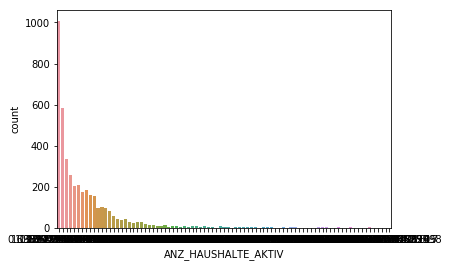

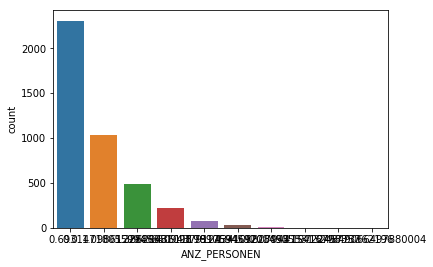

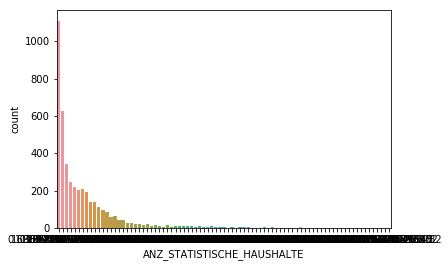

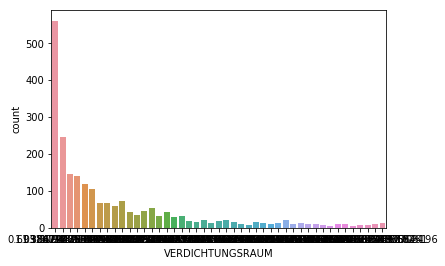

In [143]:
for col in a_test.columns:
    ax, figure = plt.subplots()
    sns.countplot(a_test[col])

From the histogram of the data, we notice that data is not normal distributed. it is therefore decided to use the min_max scaler to scale 

In [144]:
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
scaler_1 = MinMaxScaler()
scaler_2 = PowerTransformer(method='box-cox', standardize=True)
a= scaler_1.fit_transform(azdias_transformed[num_cols_min_max_scale])
b= scaler_2.fit_transform(azdias_transformed[num_cols_log_scale])

In [145]:
b

array([[-1.14216154, -0.76814045, -1.1254651 , -0.69178092],
       [ 1.07180171,  1.06366928,  1.19244898, -0.69178092],
       [ 1.00902523, -0.76814045,  0.82940341, -0.69178092],
       ...,
       [-0.34498279,  1.06366928, -1.1254651 , -0.69178092],
       [-0.34498279,  1.06366928, -0.29075145, -0.69178092],
       [-1.14216154,  1.06366928, -0.29075145, -0.69178092]])

In [146]:
# azdias_transformed[num_cols]

In [147]:
ord_cols = get_features( feat_summary, 'ordinal',azdias_transformed)

In [148]:
# from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
azdias_transformed[ord_cols] = scaler.fit_transform(azdias_transformed[ord_cols])

# Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

## pre-processing pipeline

In [149]:
def lable_encoding(azdias_transformed,
                   to_label_encoder = ["OST_WEST_KZ", "CAMEO_DEUG_2015", "CAMEO_DEU_2015", 
                                       "CAMEO_INTL_2015", 'D19_LETZTER_KAUF_BRANCHE']):
    
    le = preprocessing.LabelEncoder()
    for col in to_label_encoder:
        try:
            azdias_transformed[col].replace(np.nan, 'XXX', inplace = True)
            azdias_transformed[col] = le.fit_transform(azdias_transformed[col])
        except:
            print('{:} not in dataframe'.format(col))
    
    return azdias_transformed

In [150]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import FeatureUnion, Pipeline 
from sklearn.compose import ColumnTransformer

#Custom Transformer that extracts columns passed as argument to its constructor 
class FeatureReduction( BaseEstimator, TransformerMixin ):
    #Class Constructor 
    def __init__( self, feat_summary, features_to_keep, nan_threshold):
        self._feat_summary = feat_summary
        self._nan_threshold = nan_threshold
        self._features_to_keep = features_to_keep
    
    #Return self nothing else to do here    
    def fit( self, X, y = None ):
        return self 
    
    #Method that describes what we need this transformer to do
    def transform( self, X, y = None ):
        df_transformed = data_cleaning(X, self._feat_summary,  self._features_to_keep, self._nan_threshold)
        df_transformed = lable_encoding(df_transformed)
        df_transformed['EINGEFUEGT_AM'] = pd.DatetimeIndex(df_transformed['EINGEFUEGT_AM']).year
        df_transformed[['ANZ_HAUSHALTE_AKTIV', 'ANZ_PERSONEN',
                 'ANZ_STATISTISCHE_HAUSHALTE', "VERDICHTUNGSRAUM"]]= df_transformed[['ANZ_HAUSHALTE_AKTIV', 'ANZ_PERSONEN',
                 'ANZ_STATISTISCHE_HAUSHALTE', "VERDICHTUNGSRAUM"]].apply(np.log)
        return df_transformed

In [151]:
features_to_keep = azdias.columns.values

In [152]:
def data_cleaning(df, feat_summary, features_to_keep = None, nan_threshold=0.90):
    """clean data frame, drop redundant columns/rows
    Args: 
        df:  input data frame 
        feat_summary: meta data summary 
        nan_theshold (float): threshold for dropping rows and columns, if the ratio of nan exceedes it(<1)

    Retruns:
        df(pd.DataFrame): pandas dataframe withe reduced dimension
    """
    print('# step 1: drop attributes')
    if features_to_keep is not None:
        df = df[features_to_keep].copy()
    else:
        df = df

    print('# step 2: replace missing values or unknowns as np.nan')
    df = unkown_mapping(df, feat_summary)
    df.replace(['X', 'XX'], np.nan, inplace=True)

    print('# step 3: drop columns/rows where the portion of NA exceeds the specified threshold')
    df = drop_columns(df, threshold = nan_threshold)
    df = drop_rows(df, threshold = nan_threshold)
    # feature_count(azdias)

    return df

In [153]:
def get_features(feat_summary, typ, feat_to_keep=None):
    """Get a list of features according to the specifed feature type 

    Args:
        feat_summary (dataframe): feature summary table
        typ (str): feature type. allowable values: 'numerical', 'ordinal', 'categorical'
        df (list, optional): . Defaults to None. if provided, return only the features contained in the list 

    Returns:
        cols (list): list of the features
    """
    cols = feat_summary.loc[feat_summary['type']
                            == typ, 'Attribute'].values

    if feat_to_keep is None:
        cols = cols
    else:
        cols = np.intersect1d(cols, feat_to_keep)

    return cols

In [154]:
# Create a data processing pipeline for segmentation report.
def data_cleaing_pipeline(feat_summary,  features_to_keep=None, nan_threshold=1.0):
    """[summary]
    Args:
        feat_summary (pd.df): info on features
        features_to_keep (list): a list of features that will be processed/ to keep 
        nan_threshold (float): if the portion of nan exceeds, the row/column will be dropped

    Returns:
        data_cleaing_pipeline 
    """
    num_cols = get_features(feat_summary, typ="numerical",
                            feat_to_keep=features_to_keep)
    cat_cols = get_features(feat_summary, typ="categorical",
                            feat_to_keep=features_to_keep)
    ord_cols = get_features(feat_summary, typ="ordinal",
                            feat_to_keep=features_to_keep)

    num_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
        ('scaler', MinMaxScaler())])

    cat_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('onehot', OneHotEncoder())])

    ord_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
        ('scaler', MinMaxScaler())])

    combined_pipe = ColumnTransformer(
        transformers=[
            ('num', num_transformer, num_cols),
            ('cat', cat_transformer, cat_cols),
            ('ord', ord_transformer, ord_cols)],
        sparse_threshold=0)

    data_cleaing_pipeline = Pipeline(steps=[
        ('reduce_dimension', FeatureReduction(feat_summary,
                                              features_to_keep=features_to_keep, nan_threshold=nan_threshold)),
        ('combined_pipe', combined_pipe)])

    return data_cleaing_pipeline

In [155]:
dtype={'CAMEO_DEUG_2015': 'object', 'CAMEO_INTL_2015': 'object'}
customers = pd.read_csv('./data/Udacity_CUSTOMERS_052018.csv', sep=';',  dtype= dtype)

azdias = pd.read_csv('./data/Udacity_AZDIAS_052018.csv', sep=';', dtype = dtype)
del azdias['LNR']

In [156]:
# use azdias data to determine which are the features to keep (drop as per nan_threshold)
ppl_test = data_cleaing_pipeline(
    feat_summary, features_to_keep=None, nan_threshold=1.0)
features_to_keep = ppl_test.named_steps['reduce_dimension'].fit_transform(
    azdias).columns.values

# step 1: drop attributes
# step 2: replace missing values or unknowns as np.nan
# step 3: drop columns/rows where the portion of NA exceeds the specified threshold


In [157]:
# update the pipeline, at this step nan_threshold is set at 1.0 (no other columns will be drops due to nan's)
ppl = data_cleaing_pipeline(feat_summary, features_to_keep, nan_threshold=1.0)

In [158]:
customer_clean_data = ppl.fit_transform(customers)
cat_cols_transformed_1 = ppl.named_steps['combined_pipe'].transformers_[1][1].named_steps['onehot']\
                   .get_feature_names(cat_cols)
azdias_clean_data = ppl.fit_transform(azdias)
cat_cols_transformed_2 = ppl.named_steps['combined_pipe'].transformers_[1][1].named_steps['onehot']\
                   .get_feature_names(cat_cols)

# step 1: drop attributes
# step 2: replace missing values or unknowns as np.nan
# step 3: drop columns/rows where the portion of NA exceeds the specified threshold
# step 1: drop attributes
# step 2: replace missing values or unknowns as np.nan
# step 3: drop columns/rows where the portion of NA exceeds the specified threshold


In [159]:
num_cols_transformed = get_features(feat_summary, 'numerical', features_to_keep)
ord_cols_transformed = get_features(feat_summary, 'ordinal', features_to_keep)

In [160]:
customer_clean = pd.DataFrame(customer_clean_data, columns=np.concatenate([
                                num_cols_transformed, cat_cols_transformed_1, ord_cols_transformed]))

azdias_clean = pd.DataFrame(azdias_clean_data, columns=np.concatenate([
                                num_cols_transformed, cat_cols_transformed_2, ord_cols_transformed]))

In [161]:
compare_dataframe_columns(customer_clean, azdias_clean)

columns in df1 (None) not in df2 (None)
[]
columns in df2 (None) not in df1 (None)
['ALTERSKATEGORIE_FEIN_1.0' 'ALTER_HH_1.0' 'ALTER_KIND3_4.0'
 'D19_BANKEN_ONLINE_QUOTE_12_1.0' 'D19_TELKO_ONLINE_QUOTE_12_7.0'
 'D19_VERSI_ONLINE_QUOTE_12_3.0' 'D19_VERSI_ONLINE_QUOTE_12_6.0'
 'D19_VERSI_ONLINE_QUOTE_12_8.0' 'D19_VERSI_ONLINE_QUOTE_12_9.0'
 'GEBAEUDETYP_5.0' 'KBA13_KRSHERST_BMW_BENZ_0.0' 'KBA13_KRSSEG_KLEIN_0.0'
 'ORTSGR_KLS9_0.0' 'TITEL_KZ_2.0']


In [162]:
# compare to see if the column number match
col_to_add = list(set(cat_cols_transformed_2) - set(cat_cols_transformed_1)) 
customer_clean[col_to_add] = 0

col_to_add = list(set(cat_cols_transformed_1) - set(cat_cols_transformed_2)) 
azdias_clean[col_to_add] = 0

In [163]:
customer_clean=customer_clean.sort_index(axis=1)
azdias_clean = azdias_clean.sort_index(axis=1)

## PCA

In [164]:
# Apply PCA to the data.
from sklearn.decomposition import PCA

pca = PCA()
azdias_pca = pca.fit_transform(azdias_clean)

(0, 100)

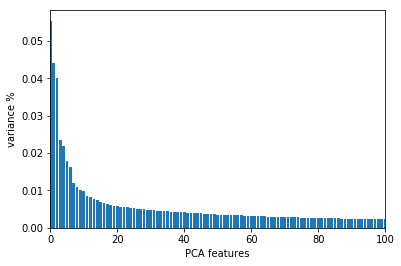

In [165]:
features = np.arange(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_)
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xlim(left = 0, right = 100)

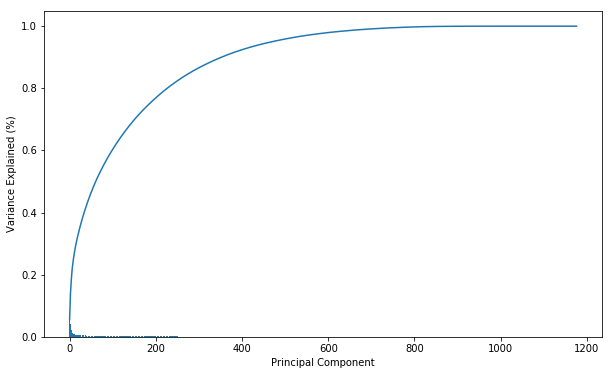

In [166]:
n_components = 300
ind = np.arange(pca.n_components_)
vals = pca.explained_variance_ratio_
plt.figure(figsize=(10, 6))


ax = plt.subplot()
cumvals = np.cumsum(vals)
ax.bar(ind, vals)
ax.plot(ind, cumvals)

for i in range(n_components):
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")

In [167]:
fig = ax.get_figure()
fig.savefig('./fig/pca_accumulated.png')

In [168]:
# Re-apply PCA to the data while selecting for number of components to retain.
n_components = features[cumvals > 0.80][0]  # determine the required principle componenth to retian 99% variance
pca = PCA(n_components)
azdias_pca = pca.fit_transform(azdias_transformed)

In [169]:
print("we will consider to include {:} PCA\'s in further analysis".format(n_components))

we will consider to include 227 PCA's in further analysis


## Interpretation of the PCA

In [170]:
pca_df = pd.DataFrame(pca.components_)
pca_df.columns = azdias_transformed.columns

In [171]:
pca_df

,ALTER_KIND1,ALTER_KIND2,ALTER_KIND4,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,BALLRAUM,...,WOHNLAGE_3.0,WOHNLAGE_4.0,WOHNLAGE_5.0,WOHNLAGE_7.0,WOHNLAGE_8.0,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6
0,0.000084,-0.000011,6.466547e-33,-0.005952,-0.000013,-0.000004,-0.000254,-0.005250,1.103153e-08,0.000210,...,0.000297,-0.000140,-0.000079,-0.000031,-3.263118e-07,0.000005,0.000294,-0.000170,-0.000053,-0.000044
1,0.004256,0.001382,-1.680008e-18,0.718276,0.004730,-0.000584,-0.008690,0.683655,-7.676753e-06,-0.004294,...,-0.000360,0.002754,0.001505,-0.003187,-4.550510e-04,-0.000907,0.000438,0.000764,0.001338,0.001501
2,0.031379,0.007666,-1.949777e-17,0.038547,0.000545,-0.002410,0.001759,0.047198,1.917019e-05,0.000015,...,0.000388,-0.000310,-0.000283,0.000183,-1.275541e-04,-0.000312,0.012448,-0.006192,-0.008602,0.001150
3,-0.018829,-0.004214,7.107733e-18,0.055632,0.000847,0.002065,0.022144,0.056823,6.335333e-05,-0.000959,...,-0.003007,-0.000687,-0.000319,0.001291,5.244173e-04,0.001589,-0.007563,0.001335,0.002620,-0.001211
4,-0.002667,-0.003140,-7.672120e-18,-0.031414,-0.001010,0.000203,-0.005031,-0.028310,-1.311572e-05,0.004550,...,-0.001241,0.003604,0.000630,-0.005144,1.541023e-04,0.000219,-0.003752,0.001702,0.000948,0.001237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,-0.003239,-0.012782,-1.767151e-17,-0.000531,-0.006415,-0.007628,0.043266,0.001029,-9.710154e-04,-0.053789,...,-0.023573,0.006667,0.059242,0.007959,-1.120096e-02,-0.004674,-0.006257,0.020894,0.023288,-0.066349
223,-0.011652,0.015833,4.816991e-18,-0.001539,-0.005616,0.032671,-0.014911,0.000731,4.213664e-04,0.006813,...,0.030172,0.000345,-0.022604,0.013036,1.213623e-02,0.010329,0.011539,-0.026720,0.002852,0.013601
224,-0.004945,-0.006002,-1.656281e-17,-0.001923,-0.005053,-0.001239,-0.024337,0.001378,1.329348e-03,-0.010584,...,0.012412,0.063860,-0.106693,0.028548,-1.221946e-02,-0.017056,-0.018814,-0.017453,0.053468,-0.038489
225,-0.008807,-0.007672,-4.926901e-17,-0.000423,-0.010344,-0.037697,-0.004490,0.000114,1.083509e-03,-0.013611,...,0.006668,-0.044552,0.033343,-0.015812,-8.709624e-04,0.002709,-0.002658,-0.007560,0.026490,-0.056950


In [172]:
df_features = pd.read_excel(
    'DIAS Information Levels - Attributes 2017.xlsx', header=[1], usecols=[2, 3], index_col=[0])
df_features = df_features.reset_index()

In [173]:
def print_pca(pca_df, pca_n, n, df_features):
    """based on the outcomes of PCA, print the mostly and least weighte of the i-th PCA

    Args: 
        pca_df (dataframe): outcomes of PCA with pca in rows and features in columns 
        pca_n (int): the (i+1)-th component to print
        n (int): features to include in summary table 

    Returns:
        None
    """

   # Highest
    print("PCA {:}".format(pca_n))
#     print("{:} attributes with the HIGHEST weight".format(n))
    pca1 = pca_df.loc[pca_n].sort_values(
        ascending=False).head(n).reset_index().copy()
    pca1.columns = ['Attribute', 'Weight']

#     try:
    pca1['Description'] = pca1['Attribute'].apply(
            lambda x: lookup_description(df_features, x))
#     except:
#         pca1['Description'] = 'not availalbe'

    display(pca1)

In [174]:
def lookup_description(df_features, key):
    try:
        description = df_features.loc[df_features["Attribute"] == key, "Description"].values[0]
    except:
        # For dummied value, split and remove the suffix in the dummies 
        try:
            key = '_'.join(key.split("_")[:-1])
            description = df_features.loc[df_features["Attribute"] == key, "Description"].values[0]
        except:
            description = 'not available'
    return description

In [175]:
# lookup_description(df_features, 'KBA13_ANZAHL_PKW')

In [205]:
for pca_n in np.arange(6):
    print_pca(pca_df, pca_n,  4, df_features)

PCA 0


,Attribute,Weight,Description
0,KBA13_ANZAHL_PKW,0.999946,number of cars in the PLZ8
1,EXTSEL992,0.001984,not available
2,VK_DISTANZ,0.000797,not available
3,CAMEO_DEU_2015_25,0.000498,CAMEO_4.0: specific group


PCA 1


,Attribute,Weight,Description
0,ANZ_HAUSHALTE_AKTIV,0.718276,number of households known in this building
1,ANZ_STATISTISCHE_HAUSHALTE,0.683655,not available
2,EXTSEL992,0.087512,not available
3,EINGEZOGENAM_HH_JAHR,0.067769,not available


PCA 2


,Attribute,Weight,Description
0,ANZ_STATISTISCHE_HAUSHALTE,0.047198,not available
1,ANZ_HAUSHALTE_AKTIV,0.038547,number of households known in this building
2,ALTER_KIND1,0.031379,not available
3,KOMBIALTER_4,0.019245,not available


PCA 3


,Attribute,Weight,Description
0,GEBURTSJAHR,0.336789,year of birth
1,ANZ_STATISTISCHE_HAUSHALTE,0.056823,not available
2,ANZ_HAUSHALTE_AKTIV,0.055632,number of households known in this building
3,EINGEFUEGT_AM,0.023218,not available


PCA 4


,Attribute,Weight,Description
0,VERDICHTUNGSRAUM,0.970666,not available
1,EINGEZOGENAM_HH_JAHR,0.212208,not available
2,EINGEFUEGT_AM,0.050753,not available
3,MIN_GEBAEUDEJAHR,0.039851,year the building was first mentioned in our d...


PCA 5


,Attribute,Weight,Description
0,EINGEZOGENAM_HH_JAHR,0.898357,not available
1,EINGEFUEGT_AM,0.228965,not available
2,MIN_GEBAEUDEJAHR,0.191747,year the building was first mentioned in our d...
3,KBA05_HERSTTEMP_5.0,0.012879,Development of the most common car manufacture...


## clustering

In [177]:
from sklearn.cluster import KMeans

clusters = 20

scores = [KMeans(n_clusters=i+2).fit(azdias_pca).inertia_ for i in range(clusters)]


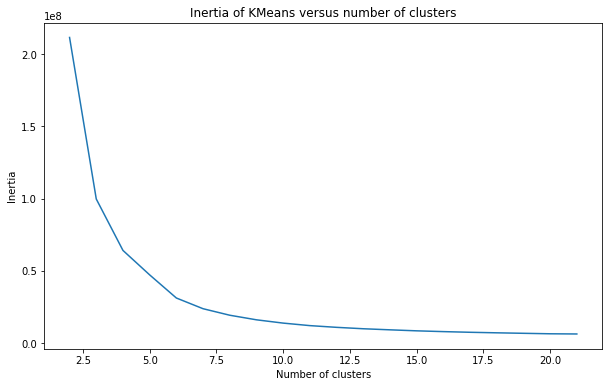

In [178]:
plt.figure(figsize=(10, 6))

sns.lineplot(np.arange(clusters) + 2, scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of KMeans versus number of clusters");
plt.savefig('./fig/knmeans.png')

## unsuperivised learning pipeline

In [206]:
pca_n = n_components 
n_clusters = 10

In [207]:
clustering_pipeline = Pipeline([
    ('pca', PCA(n_components)),
    ('kmeans', KMeans(n_clusters=n_clusters))])

In [208]:
clustering_pipeline.fit(azdias_clean)
pop_cluster = clustering_pipeline.predict(azdias_clean)
cust_cluster = clustering_pipeline.predict(customer_clean)

In [209]:
# compare_dataframe_columns(azdias_clean, customer_clean)

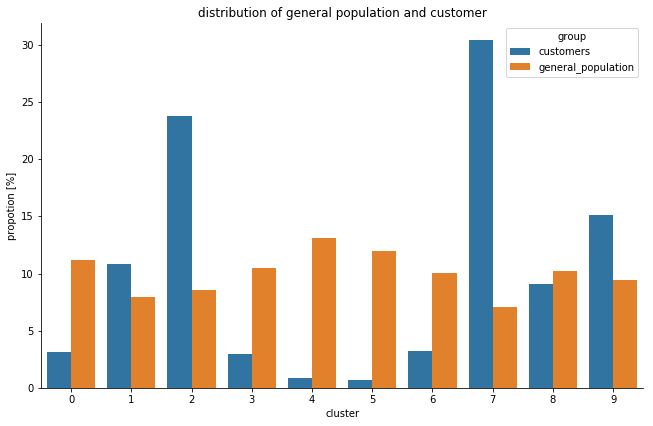

In [210]:
df_cust = pd.DataFrame()
df_cust['cluster'] = cust_cluster
df_cust['group'] = 'customers'

df_pop = pd.DataFrame()
df_pop['cluster'] = pop_cluster
df_pop['group'] = 'general_population'

df = pd.concat([df_cust, df_pop])

x, y = 'group', 'cluster'
df1 = df.groupby(x)[y].value_counts(normalize=True).mul(100)
df1 = df1.rename('percent').reset_index()

g = sns.catplot(x=y,y='percent',hue=x, kind='bar',data=df1, legend=True, legend_out=False)
g.fig.set_size_inches(10,6)

ax = g.axes.flatten()[0]
ax.set_ylabel('propotion [%]')
ax.set_title('distribution of general population and customer');
# ax.legend(bbox_to_anchor=(1.0, 1.00))

fig = ax.get_figure()
fig.savefig('./fig/cluster_compare.png')

In [211]:
df1.sort_values('cluster').groupby(by='group')['percent']

In [212]:
df1.pivot('cluster', 'group', 'percent')

group,customers,general_population
cluster,,
0,3.131718,11.182748
1,10.861875,7.913301
2,23.755557,8.585525
3,2.987707,10.511198
4,0.861457,13.086541
5,0.678313,11.948103
6,3.183374,10.061477
7,30.386325,7.053582
8,9.076347,10.182435


### difference between two data groups

In [213]:
df_diff = df1.pivot('cluster', 'group', 'percent').assign(diff = lambda x: x.customers - x.general_population).reset_index()

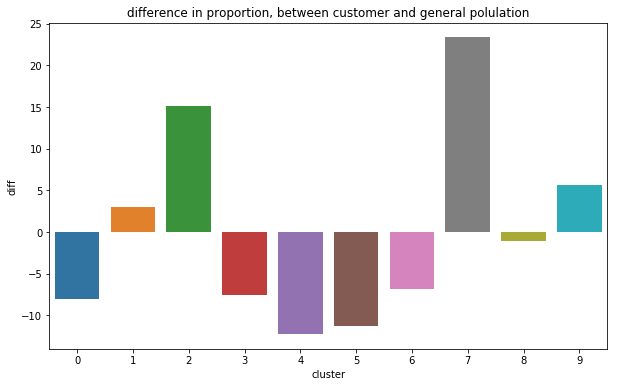

In [214]:
ax = sns.barplot(x = 'cluster', y = 'diff', data = df_diff)
fig = ax.get_figure()
fig.set_size_inches(10,6)
# ax.set_size_inches(10,6)
ax.set_title('difference in proportion, between customer and general polulation');
fig = ax.get_figure()
fig.savefig('./fig/cluster_group_differnce.png')

In [215]:
# extract distrance to center for the first 10 principle components
cluster_df = pd.DataFrame(clustering_pipeline.named_steps['kmeans'].cluster_centers_[:,:10])

In [216]:
# cluster centers shows how each gathers around for each centers at each dimension. meaning data points of this cluster will have a value close to the center of this diemnsion

### heatmap for pca

In [217]:
cluster_df

,0,1,2,3,4,5,6,7,8,9
0,1.754407,-0.726692,-2.246991,0.470690,-0.099339,-0.459415,-0.021220,0.043574,-0.057727,0.158846
1,1.501233,1.457668,1.778729,-0.953107,-0.644084,-0.912421,-0.123106,0.565875,-0.059085,0.059317
2,-2.869546,4.123500,-1.630659,1.043134,-0.108878,0.274897,0.151819,0.104334,0.102420,-0.053810
3,-1.241839,-1.477141,1.158765,0.329143,0.102731,1.619737,0.249909,-0.012302,-0.009228,-0.030522
4,-2.100539,-2.201461,-0.744268,0.197486,-0.140367,-0.746478,-0.029996,0.101409,0.079375,-0.141179
5,-0.510106,-0.367781,-1.336712,-1.572683,0.398258,-0.720045,-0.133962,-0.317023,-0.018814,-0.048649
6,0.636733,0.366082,0.297159,-1.301551,0.267922,1.476982,0.080055,-0.148021,0.104462,0.036805
7,2.001215,0.851732,1.536494,0.667584,1.291226,-0.780794,0.161486,-0.733711,0.117931,-0.204061
8,-0.809820,0.002082,2.859262,0.615657,-0.479384,-0.682158,-0.218561,0.108913,-0.269385,0.189868
9,2.903125,0.022030,-0.460887,0.864117,-0.399245,0.942299,-0.047124,0.241196,0.039797,0.010716


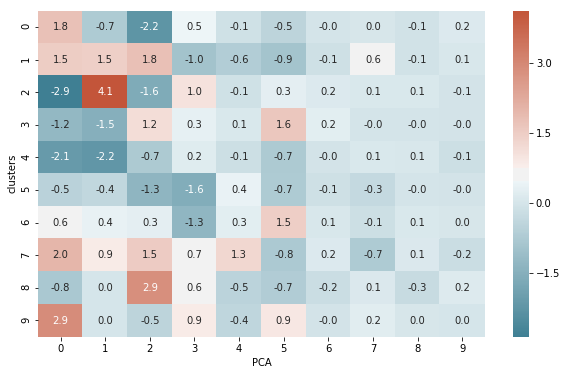

In [218]:
plt.figure(figsize=(10, 6))

cmap = sns.diverging_palette(220, 20, as_cmap=True)
ax = sns.heatmap(cluster_df, annot=True, cmap = cmap,fmt='0.1f')
ax.axes.set_xlabel('PCA')
ax.axes.set_ylabel('clusters')
fig = ax.get_figure()
fig.savefig('./fig/cluster_heatmap.png')

# Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [192]:
#Custom Transformer that extracts columns passed as argument to its constructor 
class FeatureReduction_2( BaseEstimator, TransformerMixin ):
    #Class Constructor 
    def __init__( self, feat_summary):
        self._feat_summary = feat_summary
#         self._nan_threshold = nan_threshold
#         self._features_to_keep = features_to_keep
    
    #Return self nothing else to do here    
    def fit( self, X, y = None ):
        return self 
    
    #Method that describes what we need this transformer to do
    def transform( self, X, y = None ):
        df_transformed = data_cleaning_2(X, self._feat_summary)
        df_transformed = lable_encoding(df_transformed)
        df_transformed['EINGEFUEGT_AM'] = pd.DatetimeIndex(df_transformed['EINGEFUEGT_AM']).year
        return df_transformed

In [193]:
def data_cleaning_2(df, feat_summary):
    """clean data frame, drop redundant columns/rows
    Args: 
        df:  input data frame 
        feat_summary: meta data summary 
        nan_theshold (float): threshold for dropping rows and columns, if the ratio of nan exceedes it(<1)

    Retruns:
        df(pd.DataFrame): pandas dataframe withe reduced dimension
    """
    
    print('# step 1: replace missing values or unknowns as np.nan')
    df = unkown_mapping(df, feat_summary)
    df.replace(['X', 'XX'], np.nan, inplace=True)
    
    return df

In [194]:
def data_cleaing_pipeline_2(feat_summary, num_cols, cat_cols, ord_cols):
    """[summary]
    Args:
        feat_summary (pd.df): info on features
        nan_threshold (float): if the portion of nan exceeds, the row/column will be dropped

    Returns:
        data_cleaing_pipeline 
    """
    num_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
        ('scaler', MinMaxScaler())
    ])

    cat_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('onehot', OneHotEncoder())])

    ord_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
        ('scaler', MinMaxScaler())
    ])

    combined_pipe = ColumnTransformer(
        transformers=[
            ('num', num_transformer, num_cols),
            ('cat', cat_transformer, cat_cols),
            ('ord', ord_transformer, ord_cols)],
        sparse_threshold=0)

    data_cleaing_pipeline = Pipeline(steps=[
        ('reduce_dimension', FeatureReduction_2(feat_summary)),
        ('combined_pipe', combined_pipe)])

    return data_cleaing_pipeline

In [195]:
mailout_train = pd.read_csv('./data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';', dtype = dtype)
mailout_test = pd.read_csv('./data/Udacity_MAILOUT_052018_TEST.csv', sep=';', dtype = dtype)

In [196]:
mailout_train.groupby(by ='RESPONSE')['RESPONSE'].count()/len(mailout_train)*100
n_records = len(mailout_train)
n_customer = (mailout_train['RESPONSE'] ==1).sum()
n_not_customer =  (mailout_train['RESPONSE'] ==0).sum()
n_na =  mailout_train["RESPONSE"].isna().sum()
customer_perc = n_customer/n_records*100

# Print the results
print("total records: {:}".format(n_records))
print("who became customers: {:}".format(n_customer))
print("who did not become customers: {:}".format(n_not_customer))
print("na\'s in the RESPONSE column: {:}".format(n_na))
print("portion of response: {:0.2f}%".format(customer_perc))

total records: 42962
who became customers: 532
who did not become customers: 42430
na's in the RESPONSE column: 0
portion of response: 1.24%


### use pipeline to clean the data

In [197]:
df = drop_columns(mailout_train.drop(['LNR','RESPONSE'], axis=1), threshold = 0.99)
features_to_keep = df.columns
num_cols = get_features(feat_summary, typ="numerical" , feat_to_keep=features_to_keep)
cat_cols = get_features(feat_summary, typ="categorical", feat_to_keep=features_to_keep)
ord_cols = get_features(feat_summary, typ="ordinal", feat_to_keep=features_to_keep)

In [198]:
cat_cols = np.concatenate([cat_cols, ['D19_SOZIALES']])

In [199]:
ord_cols = np.setdiff1d(ord_cols, 'D19_SOZIALES')

In [200]:
# ppl_train_test = data_cleaning(feat_summary, features_to_keep)
ppl_train = data_cleaing_pipeline_2(feat_summary, num_cols, cat_cols, ord_cols)
transformed_data = ppl_train.fit_transform(mailout_train)
cat_cols_transformed = ppl_train.named_steps['combined_pipe'].transformers_[1][1].named_steps['onehot']\
    .get_feature_names(cat_cols)

df_mailout_train_clean = pd.DataFrame(transformed_data, columns=np.concatenate([
                                 num_cols, cat_cols_transformed, ord_cols]))
# df_mailout_train_clean = df_clean_customer.copy()
df_mailout_train_clean['RESPONSE'] = mailout_train['RESPONSE']
df_mailout_train_clean.to_pickle('mailout_train_cleaned.pkl')

# step 1: replace missing values or unknowns as np.nan


In [201]:
ppl_test = data_cleaing_pipeline_2(feat_summary, num_cols, cat_cols, ord_cols)
transformed_data_test = ppl_test.fit_transform(mailout_test)
cat_cols_transformed = ppl_test.named_steps['combined_pipe'].transformers_[1][1].named_steps['onehot']\
    .get_feature_names(cat_cols)

df_mailout_test_clean = pd.DataFrame(transformed_data_test, columns=np.concatenate([
                                 num_cols, cat_cols_transformed, ord_cols]))
# df_mailout_test_clean['RESPONSE'] = mailout_test['RESPONSE']
df_mailout_test_clean.to_pickle('mailout_test_cleaned.pkl')

# step 1: replace missing values or unknowns as np.nan
